*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [349]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import requests
import zipfile
import seaborn as sns

In [2]:
files = requests.get('https://cdn.freecodecamp.org/project-data/books/book-crossings.zip',stream=True)
loc = open('book-crossings.zip','wb')
for chunk in files.iter_content(chunk_size=8192):
    loc.write(chunk)
loc.close()

In [13]:
# get data files
zipfile.ZipFile('book-crossings.zip', 'r').extractall()
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [490]:
# import csv data into dataframes
users_filename = 'BX-Users.csv'
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [367]:
print(df_ratings.isna().sum())

user      0
isbn      0
rating    0
dtype: int64


(1149780, 3)


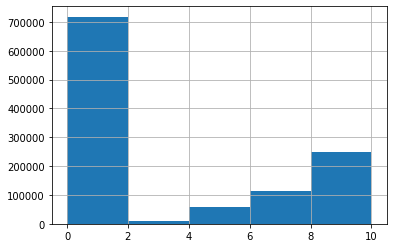

In [368]:
df_ratings["rating"].hist(bins=5)
print(df_ratings.shape)

In [491]:
print(len(df_books))
print(df_books.iloc[0])
print(df_books.isna().sum())
df_books.dropna(inplace=True)


271379
isbn               0195153448
title     Classical Mythology
author     Mark P. O. Morford
Name: 0, dtype: object
isbn      0
title     0
author    1
dtype: int64


In [492]:
df_ratings_users = df_ratings.groupby(['user'])['rating'].count().reset_index().rename(columns = {'rating':'n_ratings_p_user'})
df_ratings_books = df_ratings.groupby(['isbn'])['rating'].count().reset_index().rename(columns = {'rating':'n_ratings_p_book'})

In [432]:
df_ratings_users[df_ratings_users['n_ratings_p_user']>=200].count()

user                905
n_ratings_p_user    905
dtype: int64

In [493]:
df_ratings_books[df_ratings_books['n_ratings_p_book']>=100].count()

isbn                731
n_ratings_p_book    731
dtype: int64

In [494]:
df_ratings = df_ratings.merge(df_ratings_users)
df_ratings = df_ratings.merge(df_ratings_books)

Text(0.5, 1.0, 'Number of Ratings per User zoomed in')

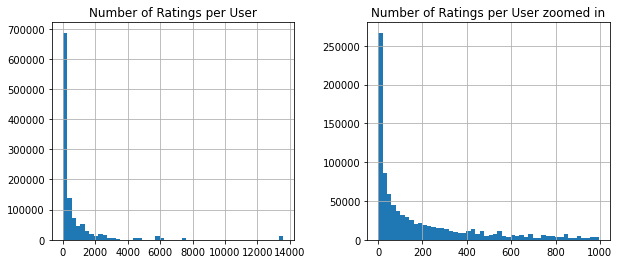

In [453]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
df_ratings[df_ratings['n_ratings_p_user']<14000].hist(column='n_ratings_p_user',bins=50, ax=ax[0])
df_ratings[df_ratings['n_ratings_p_user']<1000].hist(column='n_ratings_p_user',bins=50, ax=ax[1])
ax[0].set_title('Number of Ratings per User')
ax[1].set_title('Number of Ratings per User zoomed in')

Text(0.5, 1.0, 'Number of Ratings per Book')

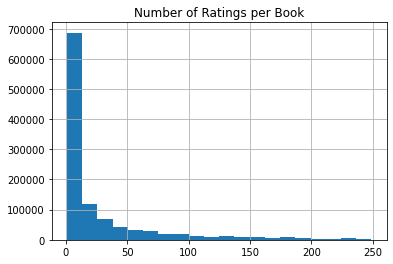

In [460]:
fig, ax = plt.subplots()
df_ratings[df_ratings['n_ratings_p_book']<250].hist(column='n_ratings_p_book',bins=20,ax=ax)
ax.set_title('Number of Ratings per Book')

In [495]:
df_ratings = df_ratings[(df_ratings['n_ratings_p_user']>=200) & (df_ratings['n_ratings_p_book']>=100)]
print(df_ratings.head(5))
print(len(df_ratings))

      user        isbn  rating  n_ratings_p_user  n_ratings_p_book
63  278418  0446520802     0.0              4533               116
65    3363  0446520802     0.0               901               116
66    7158  0446520802    10.0               400               116
69   11676  0446520802    10.0             13602               116
74   23768  0446520802     6.0              1708               116
49781


In [497]:
df_ratings_booktitles = pd.merge(df_ratings, df_books, on='isbn')

,user,isbn,rating,n_ratings_p_user,n_ratings_p_book
63,278418,0446520802,0.0,4533,116
65,3363,0446520802,0.0,901,116
66,7158,0446520802,10.0,400,116
69,11676,0446520802,10.0,13602,116
74,23768,0446520802,6.0,1708,116
...,...,...,...,...,...
550455,252071,0312971125,0.0,424,111
550457,258185,0312971125,0.0,758,111
550458,263877,0312971125,0.0,444,111
550459,265115,0312971125,10.0,1221,111


Text(0.5, 1.0, 'Most Reviewed Authors')

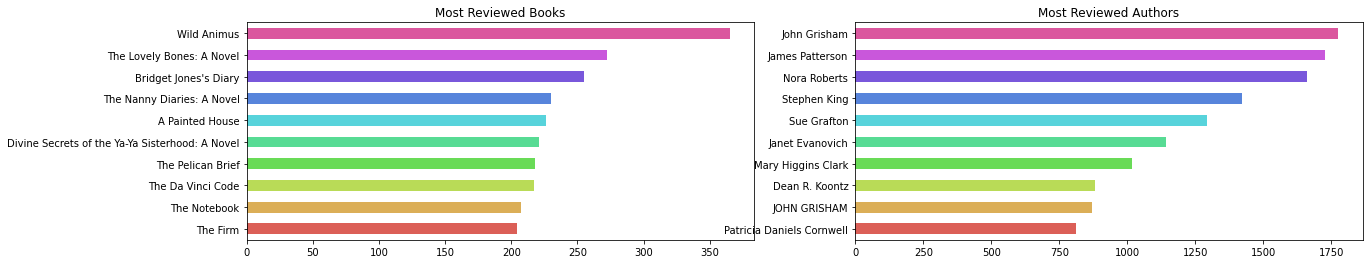

In [499]:
fig, ax = plt.subplots(1,2, figsize=(20,4))
df_ratings_booktitles['title'].value_counts()[:10].sort_values(ascending=True).plot.barh(ax=ax[0],color=sns.color_palette('hls',10))
df_ratings_booktitles['author'].value_counts()[:10].sort_values(ascending=True).plot.barh(ax=ax[1],color=sns.color_palette('hls',10))
ax[0].set_title('Most Reviewed Books')
ax[1].set_title('Most Reviewed Authors')

Text(0.5, 1.0, 'Most Reviewed Authors')

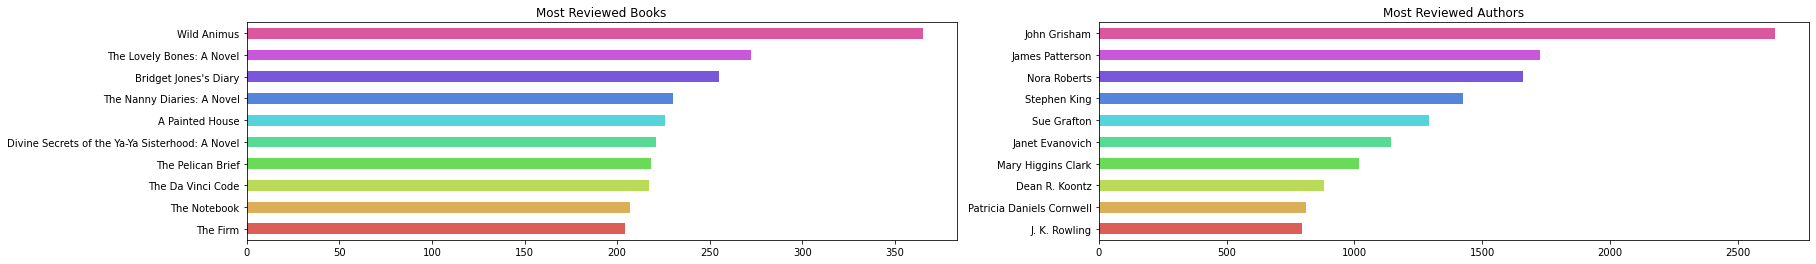

In [502]:
df_ratings_booktitles['author'].replace('JOHN GRISHAM','John Grisham', inplace=True)
fig, ax = plt.subplots(1,2, figsize=(28,4))
df_ratings_booktitles['title'].value_counts()[:10].sort_values(ascending=True).plot.barh(ax=ax[0],color=sns.color_palette('hls',10))
df_ratings_booktitles['author'].value_counts()[:10].sort_values(ascending=True).plot.barh(ax=ax[1],color=sns.color_palette('hls',10))
ax[0].set_title('Most Reviewed Books')
ax[1].set_title('Most Reviewed Authors')

In [503]:
unique_authors = df_ratings_booktitles['author'].unique()
unique_books = df_ratings_booktitles['title'].unique()
unique_users = df_ratings_booktitles['user'].unique()
print(len(unique_authors),len(unique_books),len(unique_users))

318 673 888


In [504]:
print(df_ratings_booktitles.duplicated(['title', 'user']).value_counts())

False    49136
True       381
dtype: int64


In [505]:
df_ratings_booktitles = df_ratings_booktitles.drop_duplicates(['title', 'user'])
print(df_ratings_booktitles.duplicated(['title', 'user']).value_counts())

False    49136
dtype: int64


In [509]:
df_ratings_booktitles_pivot = pd.pivot_table(df_ratings_booktitles,index='title',columns='user',values='rating').fillna(0)
print(df_ratings_booktitles_pivot.shape)
df_ratings_booktitles_matrix = csr_matrix (df_ratings_booktitles_pivot.values)
print(df_ratings_booktitles_matrix[0])

(673, 888)
  (0, 0)	9.0
  (0, 36)	9.0
  (0, 41)	8.0
  (0, 58)	7.0
  (0, 136)	9.0
  (0, 157)	10.0
  (0, 171)	9.0
  (0, 188)	8.0
  (0, 220)	10.0
  (0, 221)	10.0
  (0, 246)	10.0
  (0, 278)	10.0
  (0, 391)	10.0
  (0, 477)	9.0
  (0, 507)	9.0
  (0, 554)	10.0
  (0, 602)	9.0
  (0, 693)	9.0
  (0, 761)	8.0
  (0, 768)	7.0
  (0, 827)	10.0
  (0, 876)	10.0


In [510]:
df_ratings_booktitles_pivot

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [511]:
model_knn = NearestNeighbors (metric='cosine', algorithm = 'brute')
model_knn.fit(df_ratings_booktitles_pivot)

NearestNeighbors(algorithm='brute', metric='cosine')

In [544]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  query = df_ratings_booktitles_pivot[df_ratings_booktitles_pivot.index == book].values.reshape(1,-1)
  distances, indices = model_knn.kneighbors (query, n_neighbors=6)
  recommended = []
  for i in reversed(range(1,len(distances.flatten()))):
      recommended.append([df_ratings_booktitles_pivot.index[indices.flatten()[i]],distances.flatten()[i]])
  
  recommended_books = [book, recommended]
    
  return recommended_books

In [545]:
print(get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))"))


["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]


Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [546]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
